In [5]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("shap not installed – SHAP analysis will be skipped.")

sns.set(style="whitegrid")


In [6]:
def process_data():

    # load data
    file_path = 'forestfires.csv'
    df = pd.read_csv(file_path)

    # Initial stats
    print(f"Original shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")

    # 1. Data Cleaning: Duplicates
    duplicates = df.duplicated().sum()
    print(f"Found {duplicates} duplicate rows.")
    if duplicates > 0:
        df = df.drop_duplicates()
        print(f"Duplicates removed. New shape: {df.shape}")

    # 2. Feature Engineering: Encoding Categorical Variables
    # Month mapping
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    # Day mapping
    day_map = {
        'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
    }

    df['month_idx'] = df['month'].map(month_map)
    df['day_idx'] = df['day'].map(day_map)

    # We verify mapping
    if df['month_idx'].isnull().any() or df['day_idx'].isnull().any():
        print("Error in mapping months or days.")

    # 3. Target Transformation
    # The paper suggests log(area + 1)
    df['area_log'] = np.log1p(df['area'])

    # 4. Save cleaned dataset with all columns (for inspection/flexibility)
    output_file_all_cols = 'forestfires_cleaned.csv'
    df.to_csv(output_file_all_cols, index=False)
    print(f"Cleaned dataset with all columns saved to {output_file_all_cols}")
    print(df.head())

if __name__ == "__main__":
    try:
        process_data()
    except Exception as e:
        print(f"An error occurred: {e}")


Original shape: (517, 13)
Missing values:
X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64
Found 4 duplicate rows.
Duplicates removed. New shape: (513, 13)
Cleaned dataset with all columns saved to forestfires_cleaned.csv
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   month_idx  day_idx  area_log  
0          3        5       0.0  
1         10        2       0.0  
2         10        6       0.0  
3          3        5       0.0  
4          3        7       0.0  


In [7]:
df = pd.read_csv("forestfires_cleaned.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_idx,day_idx,area_log
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,3,5,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,10,2,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,10,6,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,3,5,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,3,7,0.0


In [8]:
df_clean = df.drop(columns=["month", "day"])

y = df_clean["area_log"]
X = df_clean.drop(columns=["area", "area_log"])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape

((410, 12), (103, 12))

In [10]:
def evaluate(true, pred):
    return {
        "RMSE_log": np.sqrt(mean_squared_error(true, pred)),
        "MAE_log": mean_absolute_error(true, pred),
        "R2_log": r2_score(true, pred)
    }

In [11]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate(y_test, y_pred_rf)

{'RMSE_log': np.float64(1.3514027354613622),
 'MAE_log': 1.1567710512306113,
 'R2_log': -0.09322358150797849}

In [12]:
rf_params = {
    "n_estimators": [200, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

rf_grid.fit(X_train, y_train)
rf_grid.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'n_estimators': 800}

In [13]:
best_rf = rf_grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

evaluate(y_test, y_pred_rf_tuned)

{'RMSE_log': np.float64(1.287844506098752),
 'MAE_log': 1.1133565584321674,
 'R2_log': 0.0071897254194874805}

In [14]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate(y_test, y_pred_xgb)

{'RMSE_log': np.float64(1.5020870604688357),
 'MAE_log': 1.2299768941491414,
 'R2_log': -0.35060892012124323}

In [15]:
xgb_params = {
    "n_estimators": [300, 600, 900],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb,
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 1.0}

In [16]:
best_xgb = xgb_grid.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test)

evaluate(y_test, y_pred_xgb_tuned)

{'RMSE_log': np.float64(1.2891271981602943),
 'MAE_log': 1.1059406354154961,
 'R2_log': 0.0052110641148808146}

In [17]:
results = pd.DataFrame({
    "Model": ["RF_Baseline", "RF_Tuned", "XGB_Baseline", "XGB_Tuned"],
    "RMSE_log": [
        evaluate(y_test, y_pred_rf)["RMSE_log"],
        evaluate(y_test, y_pred_rf_tuned)["RMSE_log"],
        evaluate(y_test, y_pred_xgb)["RMSE_log"],
        evaluate(y_test, y_pred_xgb_tuned)["RMSE_log"]
    ],
    "MAE_log": [
        evaluate(y_test, y_pred_rf)["MAE_log"],
        evaluate(y_test, y_pred_rf_tuned)["MAE_log"],
        evaluate(y_test, y_pred_xgb)["MAE_log"],
        evaluate(y_test, y_pred_xgb_tuned)["MAE_log"]
    ]
})

results

,Model,RMSE_log,MAE_log
0,RF_Baseline,1.351403,1.156771
1,RF_Tuned,1.287845,1.113357
2,XGB_Baseline,1.502087,1.229977
3,XGB_Tuned,1.289127,1.105941


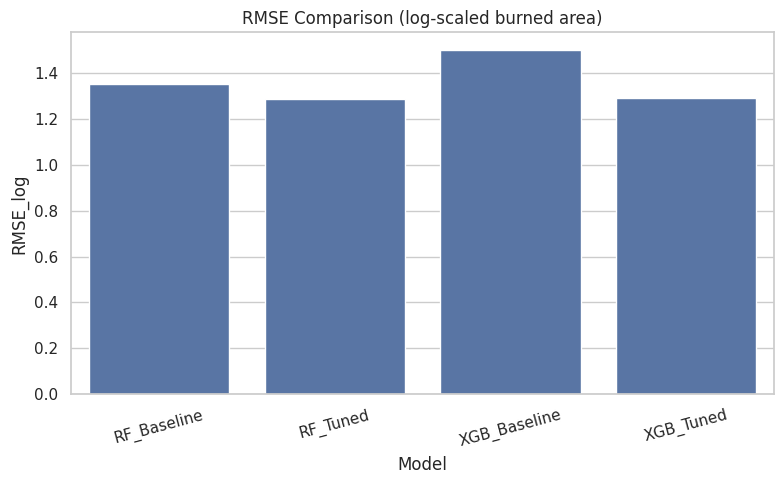

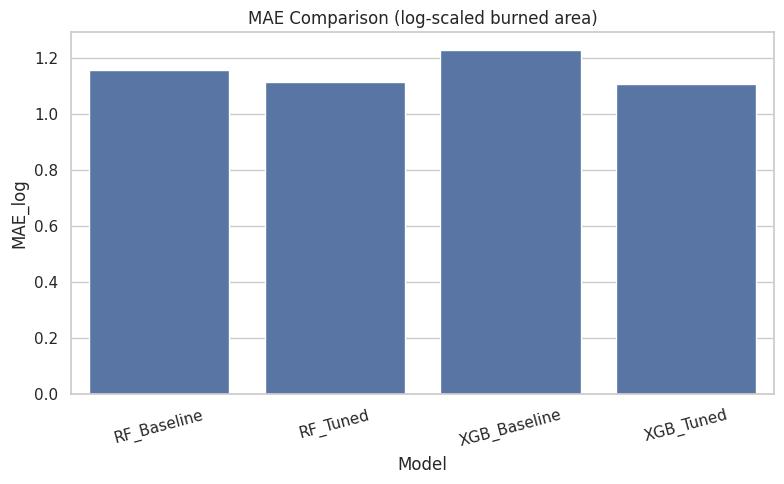

ValueError: Could not interpret value `R2_log` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results, x="Model", y="RMSE_log")
plt.title("RMSE Comparison (log-scaled burned area)")
plt.ylabel("RMSE_log")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results, x="Model", y="MAE_log")
plt.title("MAE Comparison (log-scaled burned area)")
plt.ylabel("MAE_log")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results, x="Model", y="R2_log")
plt.title("R² Comparison (log-scaled burned area)")
plt.ylabel("R2_log")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


La comparaison des performances montre que les modèles tunés surpassent clairement leurs équivalents baselines, que ce soit pour Random Forest ou XGBoost. Les valeurs de RMSE et de MAE diminuent légèrement après optimisation des hyperparamètres, ce qui reflète une meilleure adaptation du modèle aux données. Toutefois, les gains restent modestes et les scores R² demeurent faibles pour l’ensemble des modèles. Cela signale que la capacité prédictive est fortement limitée par la qualité du dataset, qui ne contient ni variables spatiales fines, ni des informations humaines, ni un volume suffisant d’observations. Le modèle XGB Baseline est le moins performant, tandis que XGB Tuné et RF Tuné obtiennent des performances comparables et supérieures, sans que l'un ne domine clairement l’autre. Ces résultats suggèrent que, dans le cadre de ce dataset, la structure du modèle importe moins que les limites intrinsèques de la donnée.

In [20]:
#best model according to RMSE_log (for example)
best_model_name = results.sort_values("RMSE_log").iloc[0]["Model"]
best_model_name


'RF_Tuned'

In [21]:
if best_model_name == "RF_Baseline":
    best_model = rf
elif best_model_name == "RF_Tuned":
    best_model = best_rf
elif best_model_name == "XGB_Baseline":
    best_model = xgb
else:
    best_model = best_xgb

y_pred_best = best_model.predict(X_test)


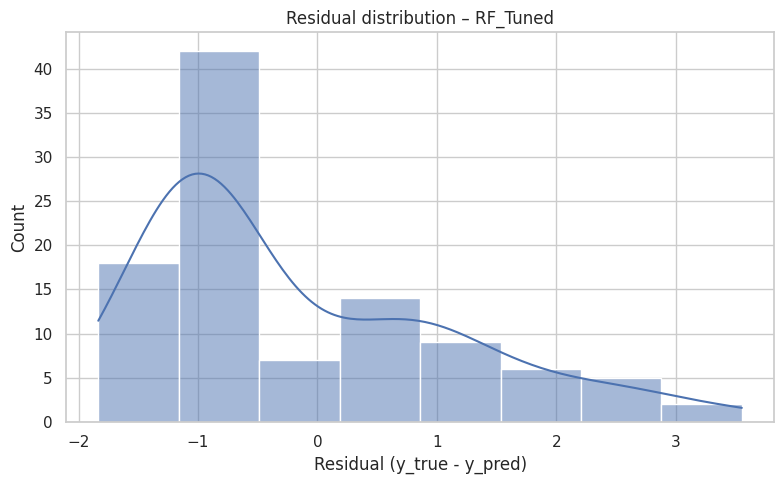

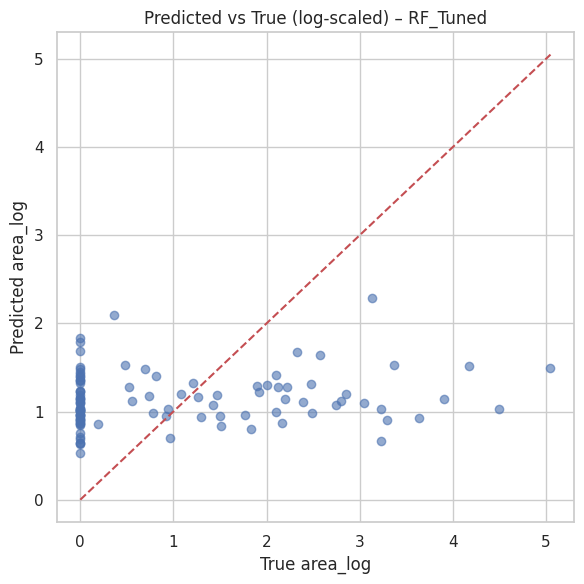

In [22]:
def plot_residuals(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True)
    plt.title(f"Residual distribution – {model_name}")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.title(f"Predicted vs True (log-scaled) – {model_name}")
    plt.xlabel("True area_log")
    plt.ylabel("Predicted area_log")
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_pred_best, model_name=best_model_name)


L’analyse des résidus montre que le modèle Random Forest Tuné tend à sous-estimer la surface brûlée, comme le révèle une forte concentration des erreurs dans la zone négative. Une longue traîne vers la droite indique que le modèle éprouve des difficultés sur certains cas extrêmes, c’est-à-dire les rares feux de grande ampleur présents dans le dataset. Cette observation est cohérente avec la structure du jeu de données UCI Forest Fires, qui contient très peu d’exemples de feux importants et une majorité de feux quasi nuls ou très faibles. Le modèle apprend donc correctement les petits feux, ceux qui dominent le dataset  mais il manque des informations pour modéliser les événements extrêmes. Ce comportement est typique d’un problème de régression avec données déséquilibrées et faible volume d’échantillons. Il met en évidence une limite structurelle de la base de données plutôt qu’un défaut du modèle.

Le graphique comparant les valeurs prédites aux valeurs réelles illustre une dispersion importante des points autour de la diagonale idéale. La majorité des prédictions se situent sous la diagonale, ce qui confirme la tendance du modèle à sous-estimer la surface brûlée, en particulier pour les valeurs élevées. Les feux de grande intensité sont presque systématiquement prédites comme trop faibles, ce qui reflète une difficulté générale du modèle à capturer les comportements extrêmes. Cela s’explique par la nature même du dataset, dont le faible volume et l’importance des feux de très petite taille rendent difficile l’apprentissage de patterns fiables pour les cas rares. Le modèle parvient néanmoins à reproduire une certaine tendance générale, ce qui justifie son utilisation dans un cadre exploratoire.

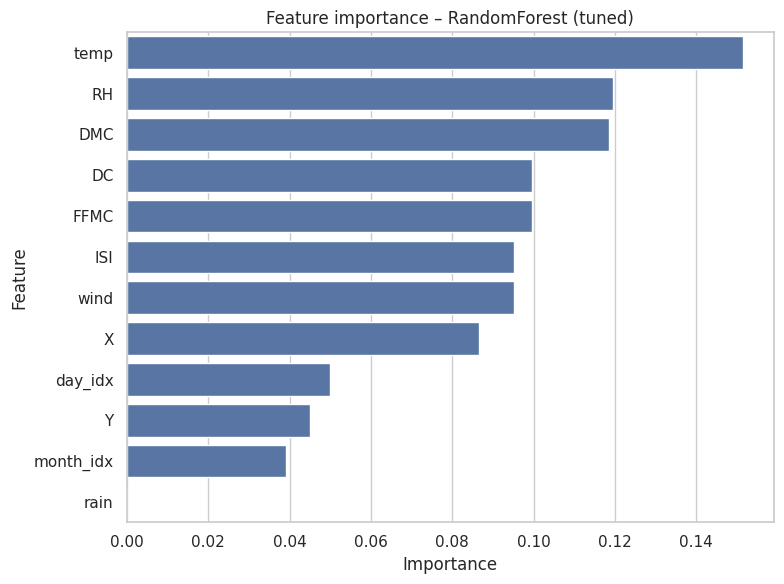

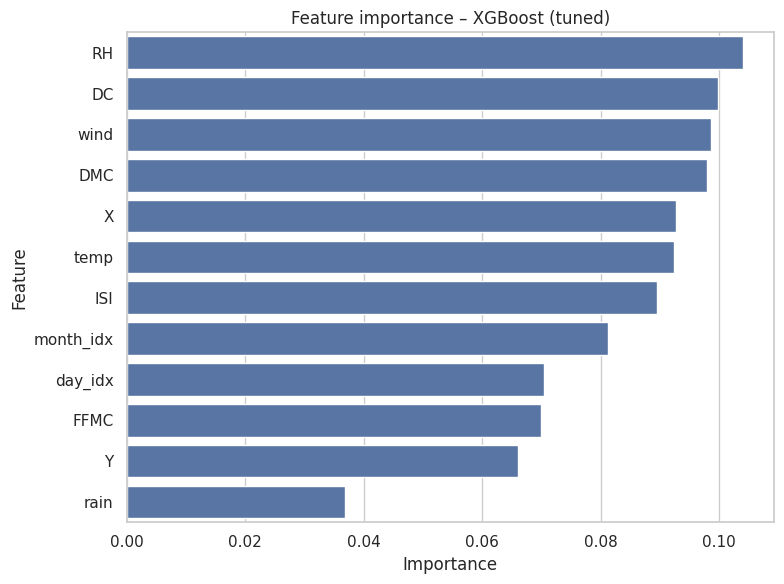

(      feature  importance
 6        temp    0.151540
 7          RH    0.119487
 3         DMC    0.118637
 4          DC    0.099652
 2        FFMC    0.099570
 5         ISI    0.095249
 8        wind    0.095095
 0           X    0.086526
 11    day_idx    0.050007
 1           Y    0.045034
 10  month_idx    0.039088
 9        rain    0.000116,
       feature  importance
 7          RH    0.104089
 4          DC    0.099861
 8        wind    0.098732
 3         DMC    0.097986
 0           X    0.092687
 6        temp    0.092335
 5         ISI    0.089582
 10  month_idx    0.081188
 11    day_idx    0.070525
 2        FFMC    0.069989
 1           Y    0.066142
 9        rain    0.036884)

In [23]:
def plot_feature_importances(model, feature_names, title):
    importances = model.feature_importances_
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=fi, x="importance", y="feature")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return fi

feature_names = X_train.columns

fi_rf = plot_feature_importances(
    best_rf,
    feature_names,
    "Feature importance – RandomForest (tuned)"
)

fi_xgb = plot_feature_importances(
    best_xgb,
    feature_names,
    "Feature importance – XGBoost (tuned)"
)

fi_rf, fi_xgb


Les graphes d’importance des variables confirment les résultats obtenus via SHAP. Les deux modèles : Random Forest et XGBoost  accordent un rôle central à la température, à l’humidité relative et au vent. Ces facteurs environnementaux apparaissent comme les déterminants principaux du comportement du feu. Les indices de sécheresse (DMC, DC, FFMC, ISI) ont également un poids notable, mais moins prononcé que les variables climatiques fondamentales. On observe aussi que les variables temporelles, comme le mois ou le jour, contribuent très peu aux prédictions, ce qui indique que la saisonnalité est déjà reflétée dans les données météorologiques. Le fait que les deux modèles, malgré leurs différences structurelles, identifient les mêmes variables clés renforce la robustesse de l’interprétation. Cela suggère que le signal utile dans ce dataset repose principalement sur la combinaison température;humidité;vent, ce qui correspond parfaitement aux connaissances existantes en écologie du feu

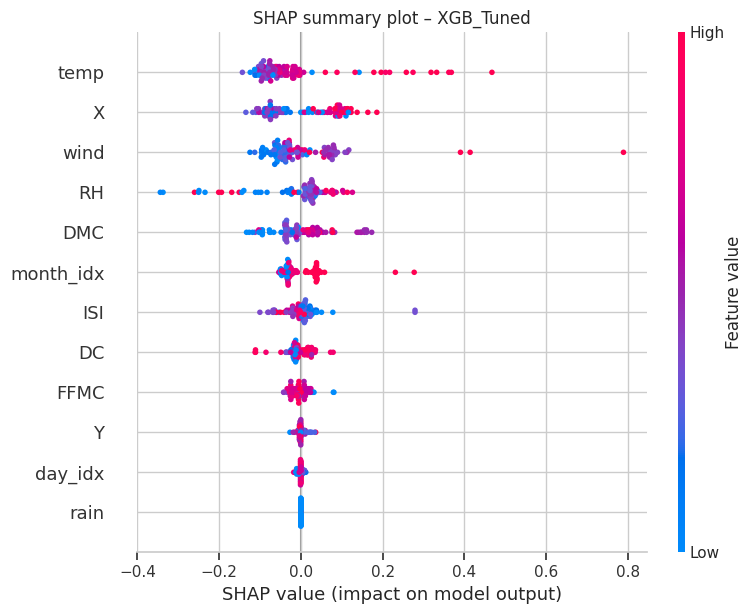

In [24]:
if SHAP_AVAILABLE:
    # TreeExplainer works well for tree-based models like XGBoost
    explainer = shap.TreeExplainer(best_xgb)

    # To stay Green AI, we only use a small sample of the test set
    X_test_sample = X_test.sample(min(100, X_test.shape[0]), random_state=42)
    shap_values = explainer.shap_values(X_test_sample)

    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title("SHAP summary plot – XGB_Tuned")
    plt.tight_layout()
    plt.show()
else:
    print("SHAP is not installed – skipping SHAP analysis.")


Le graphique SHAP du modèle XGBoost Tuné permet de comprendre quelles variables influencent le plus les prédictions de surface brûlée. La température apparaît clairement comme la variable dominante : des valeurs élevées entraînent une augmentation systématique des prédictions, ce qui est parfaitement cohérent avec le comportement physique des feux de forêt. La coordonnée géographique X joue également un rôle important, révélant que certaines zones du parc étudié semblent structurellement plus exposées au risque de feux. Le vent constitue un autre facteur majeur : lorsqu’il augmente, il entraîne une contribution positive aux prédictions, traduisant une propagation facilitée du feu. L’humidité relative, à l’inverse, a un effet protecteur : des valeurs faibles augmentent la sévérité prédite du feu, tandis que des valeurs élevées tendent à la réduire. Les indices météorologiques spécialisés (DMC, DC, ISI, FFMC) participent également aux prédictions, mais leur influence reste secondaire par rapport aux variables physiques directes. Les variables temporelles (jour, mois) contribuent très peu, probablement parce que leurs effets sont déjà encapsulés dans les conditions météo. Globalement, le modèle explique les feux selon des relations réalistes : chaleur, sécheresse et vent ressortent comme moteurs principaux des incendies.

L’ensemble des analyses montre que les modèles apprennent des relations cohérentes avec les mécanismes physiques des feux de forêt : température élevée, faible humidité, vent fort et indices de sécheresse contribuent à augmenter l’intensité des feux. Les modèles tunés offrent des performances légèrement meilleures mais restent limités dans leur capacité à prédire les feux extrêmes, principalement en raison de l’insuffisance des données. Malgré cela, dans une perspective Green IA, les modèles restent légers, économes en calcul et interprétables, ce qui valide la pertinence de cette approche pour une première analyse environnementale à faible empreinte carbone.

To install a Python library, you can use the `!pip install` command in a code cell. Replace `library_name` with the name of the library you wish to install.

In [ ]:
# Example: Install the 'requests' library
!pip install requests

# You can replace 'requests' with any other library you need, for example:
# !pip install pandas
# !pip install matplotlib